In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1. Выделение краев алгоритмом Canny:

In [114]:
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 150)
    return edges

# 2.пороговым методом с глобальным порогом T, реализовать определение порога:

## 2.1 Определение порога на основе площади (P-tile)

In [115]:
def ptile_threshold(image, p):
    flat_image = image.flatten()
    flat_image.sort()
    idx = int(len(flat_image) * p)
    threshold = flat_image[idx]
    return threshold

## 2.2 Пороговый метод с последовательными приближениями

In [116]:
def iterative_threshold(image, initial_threshold=128, max_iterations=100, tolerance=1):
    old_threshold = initial_threshold
    new_threshold = 0
    for _ in range(max_iterations):
        below_threshold = image < old_threshold
        above_threshold = image >= old_threshold
        mean_below = np.mean(image[below_threshold])
        mean_above = np.mean(image[above_threshold])
        new_threshold = (mean_below + mean_above) / 2
        if abs(new_threshold - old_threshold) < tolerance:
            break
        old_threshold = new_threshold
    return new_threshold


## 2.3 Метод k-средних

In [134]:
def kmeans_threshold(image, k, downscale_factor=0.5, max_iter=10, epsilon=1.0):
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray = image
    else:
        small_image = cv2.resize(image, (0,0), fx=downscale_factor, fy=downscale_factor)
        gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)
    data = gray.reshape((-1, 1)).astype(np.float32)

    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    threshold = int(centers[-1][0])
    return threshold

2.4 (для 2.2 и 2.3) добавить гистограмму изображения для поиска на
ней пиков и последующего их сглаживания (реализовать в программе
сравнение при нескольких различных количествах сглаживаний).

In [118]:
def calculate_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    return hist

def smooth_histogram(hist, smoothing_factor=1, smooth_count=1):
    from scipy.ndimage.filters import gaussian_filter
    for i in range(smoothing_factor):
        hist = gaussian_filter(hist, smooth_count)
    return hist

In [150]:
def iterative_threshold_with_hist(image, initial_threshold=128, max_iterations=100, tolerance=1, smooth_counts: list =None):
    if smooth_counts is None:
        smooth_counts = [1, ]

    plt.figure(figsize=(10, len(smooth_counts) * 3))

    for i, smooth_count in enumerate(smooth_counts):
        hist = calculate_histogram(image)
        smoothed_hist = smooth_histogram(hist, smooth_count)
        peaks, _ = find_peaks(smoothed_hist)

        new_threshold = iterative_threshold(image, initial_threshold, max_iterations, tolerance)
        
        ax = plt.subplot(len(smooth_counts), 1, i + 1)
        ax.set_title("Histogram After Smoothing (smooth_count={}, peaks={})".format(smooth_count, len(peaks)))
        ax.plot(smoothed_hist, color='blue')
        ax.scatter(peaks, smoothed_hist[peaks], color='orange', label='Peaks')
        ax.axvline(x=new_threshold, color='red', label='Threshold: {:.2f}'.format(new_threshold))
        ax.legend()

    plt.tight_layout()
    plt.show()

In [120]:
def kmeans_threshold_with_hist(image, k, smoothing_factor=1):
    hist = calculate_histogram(image)
    smoothed_hist = smooth_histogram(hist, smoothing_factor)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(smoothed_hist.reshape(-1, 1).astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    threshold = int(centers[-1][0])

    plt.figure()
    plt.title("Histogram After Smoothing (factor={})".format(smoothing_factor))
    plt.plot(smoothed_hist, color='blue')
    plt.axvline(x=threshold, color='red', label='Threshold')
    plt.legend()
    plt.show()

    return threshold

# 3. Пороговый метод с адаптивным порогом

In [121]:
def threshold_adaptive_method(data, k_values, c_methods, t_values):
    results = []

    for k in k_values:
        for c_method in c_methods:
            for t in t_values:
                predictions = []
                for row in data:
                    threshold = calculate_threshold(row, k, c_method)
                    row_predictions = []
                    for element in row:
                        if element > threshold:
                            row_predictions.append(1)
                        else:
                            row_predictions.append(0)
                    predictions.append(row_predictions)
                
                results.append((k, c_method, t, predictions))
    
    return results

def calculate_threshold(data, k, c_method):
    c = 0

    if c_method == 'mean':
        c = np.mean(data)
    elif c_method == 'median':
        c = np.median(data)
    elif c_method == 'mean_max_min':
        c = (np.max(data) + np.min(data)) / 2
    
    return c + k * np.std(data)

# 4. Обработка видео

In [132]:
def process_video(video_path, threshold_type='default frame'):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        if threshold_type != 'default frame':
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        if threshold_type == 'kmeans':
            threshold = kmeans_threshold(frame, k=10)
            method_text = 'K-Means Thresholding'
        elif threshold_type == 'iterative':
            threshold = iterative_threshold(frame, initial_threshold=20, max_iterations=1000)
            method_text = 'Iterative Thresholding'
        elif threshold_type == 'ptile':
            threshold = ptile_threshold(frame, 0.2)
            method_text = 'Percentile Thresholding'
        elif threshold_type == 'adaptive':
            k_values = [2]
            c_methods = ['mean_max_min']
            t_values = [2]
            results = threshold_adaptive_method(image, k_values, c_methods, t_values)
            frame = results[0][3]
            threshold = None
            method_text = 'Adaptive Thresholding'
        else:
            threshold = None
            method_text = 'Default Frame Processing'
        
        if threshold is not None:
            _, thresholded_frame = cv2.threshold(frame, threshold, 255, cv2.THRESH_BINARY)
            edges = thresholded_frame
        else:
            if threshold_type == 'adaptive':
                edges = np.array(frame, dtype=np.uint8)
            else:
                edges = detect_edges(frame)
                edges = cv2.convertScaleAbs(edges)
        
        if edges.dtype != np.uint8:
            edges = np.array(edges, dtype=np.uint8)
        
        cv2.putText(edges, method_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Edges', edges)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()

# Демонстрация работы

In [123]:
image_path = '../assets/warning.jpeg'
image_color = cv2.imread(image_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

/var/folders/yp/7vb_5yfd4w5_z9ks3yltmsk00000gn/T/ipykernel_88198/3851232810.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


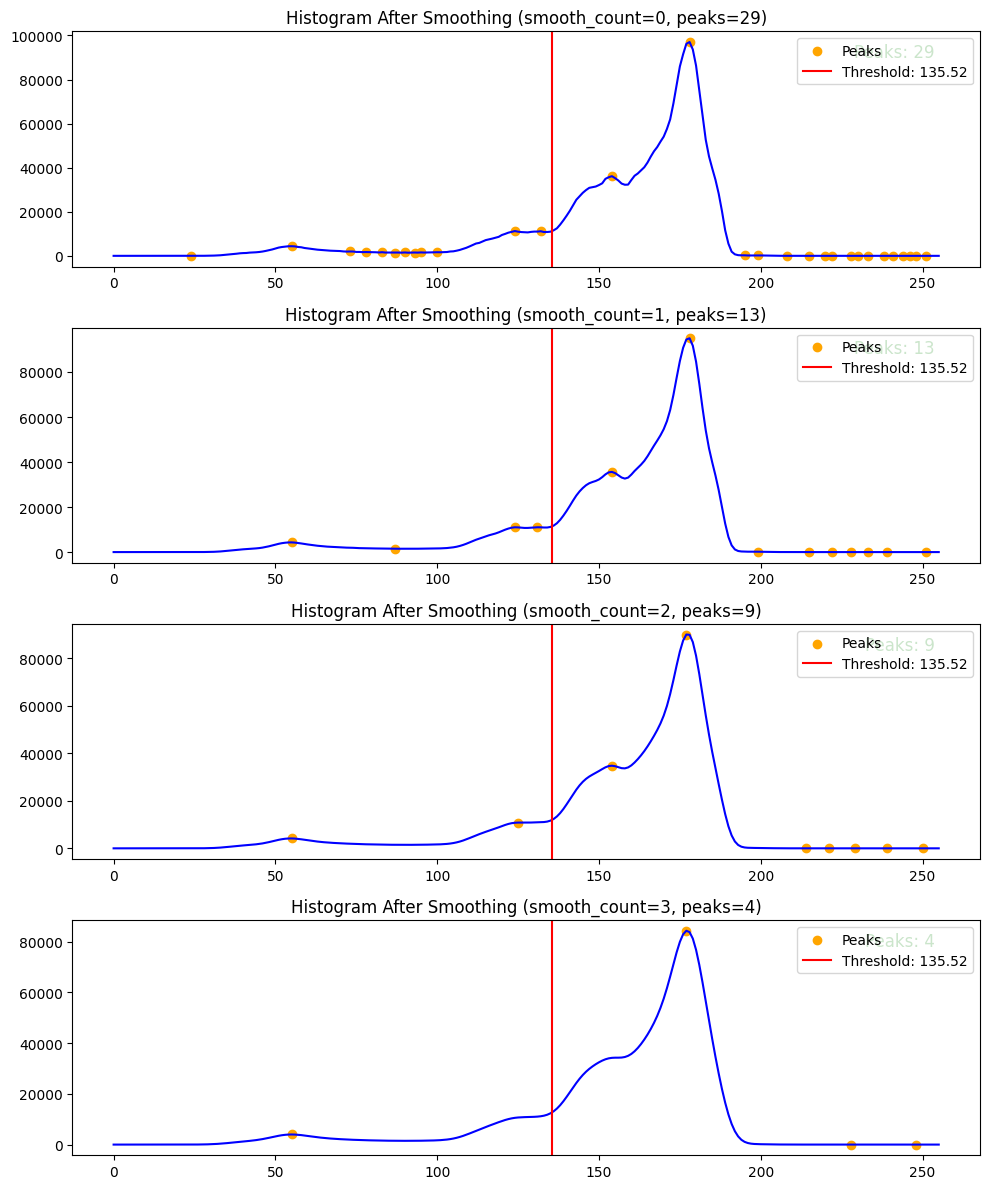

In [149]:
iterative_threshold_with_hist(image,250, smooth_counts=[0, 1, 2, 3])

144
133.89386277346466
173


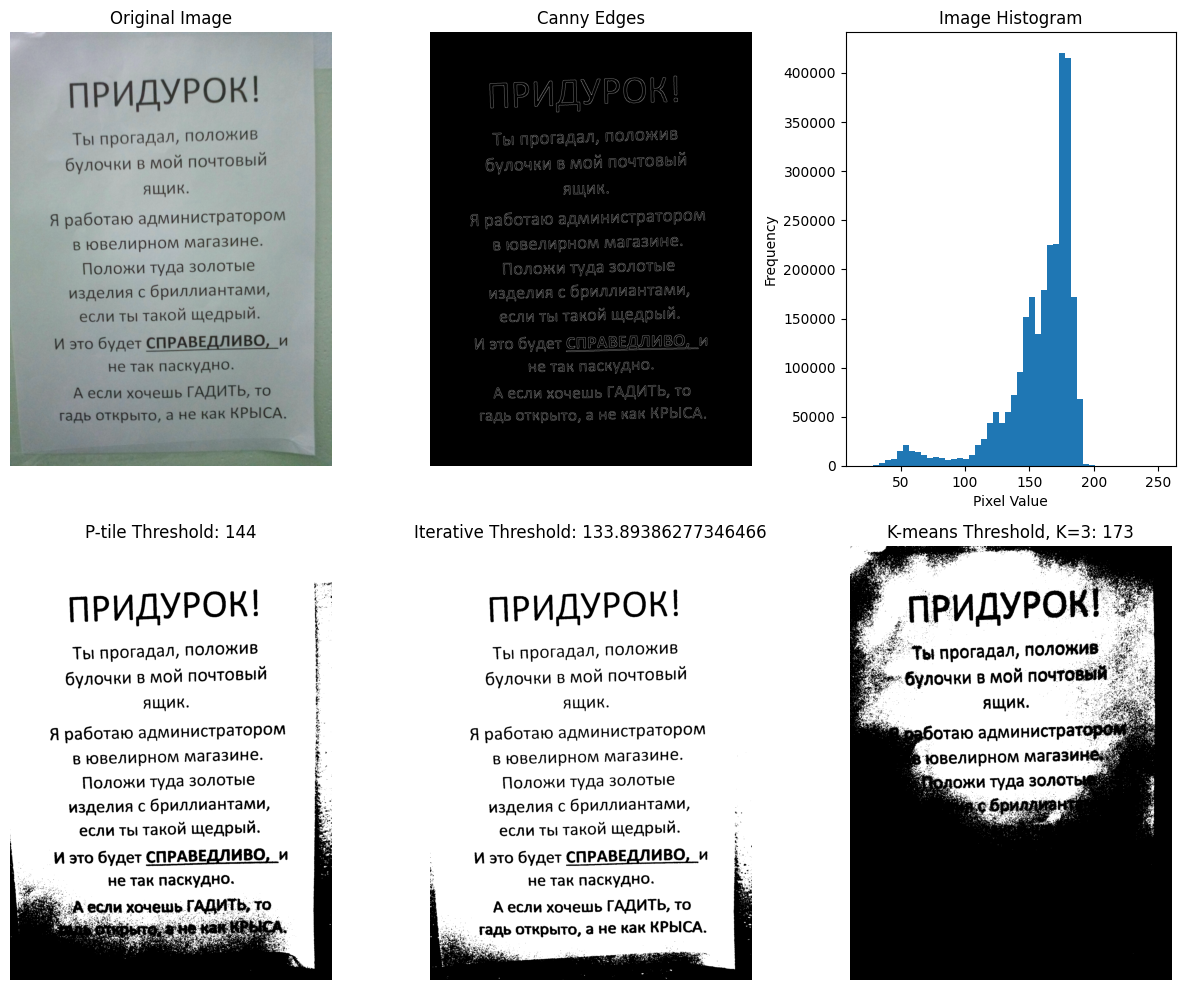

/var/folders/yp/7vb_5yfd4w5_z9ks3yltmsk00000gn/T/ipykernel_88198/3643117576.py:30: RuntimeWarning: overflow encountered in scalar add
  c = (np.max(data) + np.min(data)) / 2


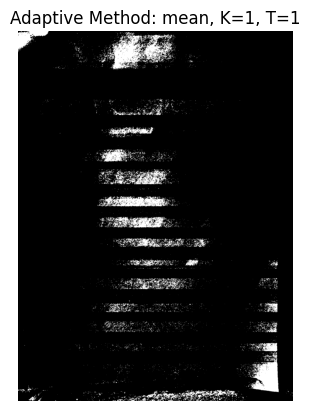

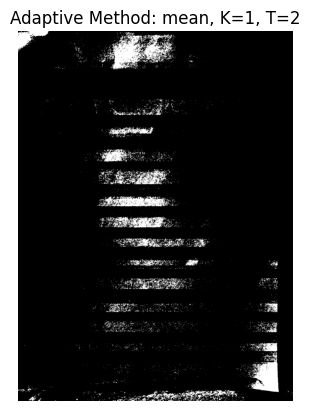

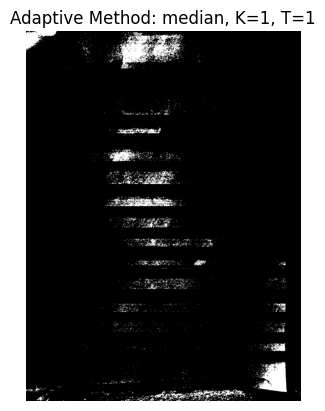

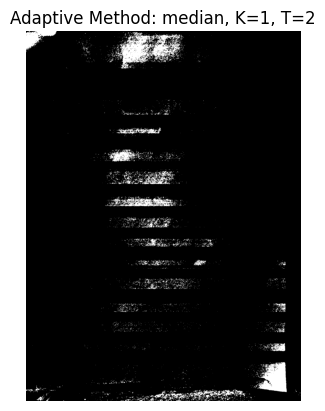

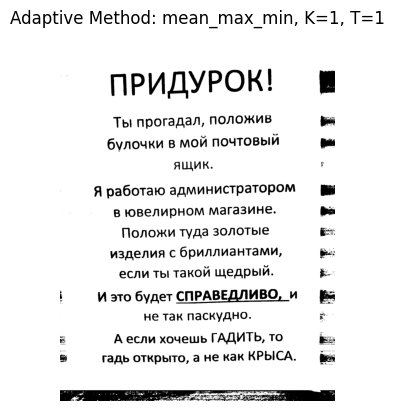

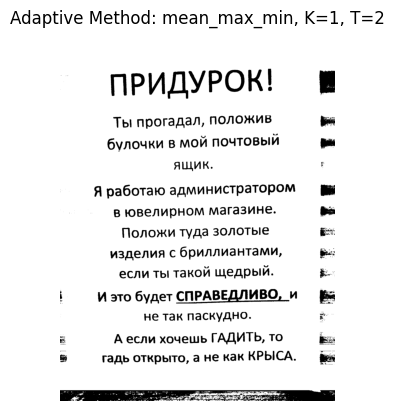

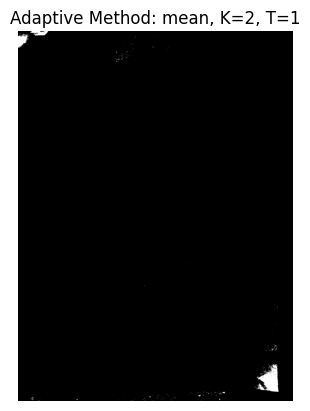

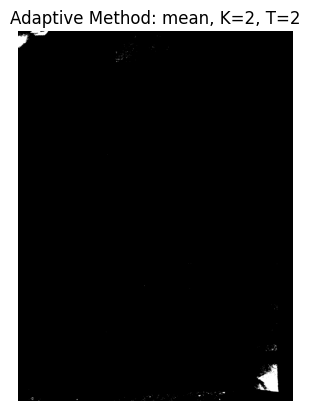

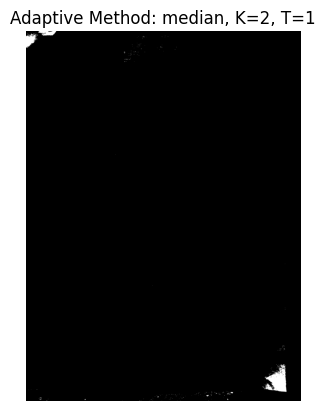

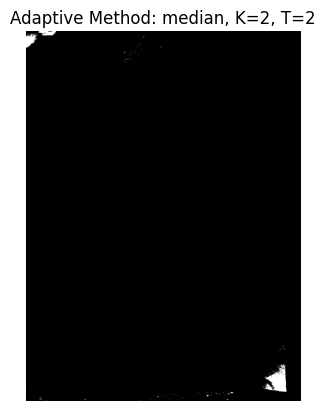

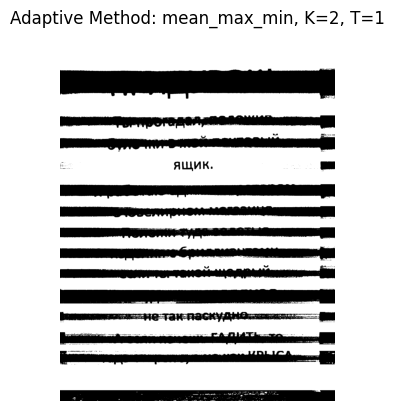

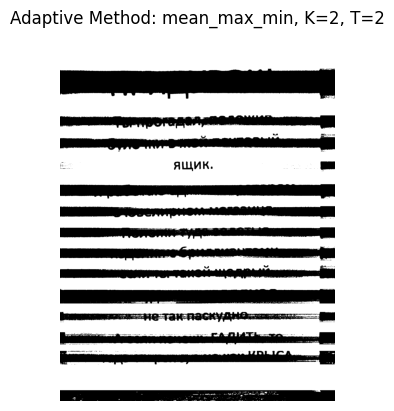

In [153]:
edges = detect_edges(image_color)

p = 0.2
ptile_thresh = ptile_threshold(image, p)
print(ptile_thresh)

iter_thresh = iterative_threshold(image, initial_threshold=20, max_iterations=1000)
print(iter_thresh)

k = 3
kmeans_thresh = kmeans_threshold(image, k)
print(kmeans_thresh)

plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_color)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.hist(image.flatten(), bins=50)
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.imshow(image > ptile_thresh, cmap='gray')
plt.title(f'P-tile Threshold: {ptile_thresh}')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image > iter_thresh, cmap='gray')
plt.title(f'Iterative Threshold: {iter_thresh}')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image > kmeans_thresh, cmap='gray')
plt.title(f'K-means Threshold, K={k}: {kmeans_thresh}')
plt.axis('off')

plt.tight_layout()
plt.savefig('thresholding_summary.png')
plt.show()

k_values = [1, 2]
c_methods = ['mean', 'median', 'mean_max_min']
t_values = [1, 2]

results = threshold_adaptive_method(image, k_values, c_methods, t_values)
for k, c_method, t_value, thresholded_image in results:
    plt.imshow(thresholded_image, cmap='gray')
    plt.title(f'Adaptive Method: {c_method}, K={k}, T={t_value}')
    plt.axis('off')
    filename = f'adaptive_{c_method}_K{k}_T{t_value}.png'
    plt.savefig(filename)
    plt.show()

In [126]:
video_path = '../assets/video.mp4'
process_video(video_path)

In [133]:
process_video(video_path, 'adaptive')

/var/folders/yp/7vb_5yfd4w5_z9ks3yltmsk00000gn/T/ipykernel_88198/3643117576.py:30: RuntimeWarning: overflow encountered in scalar add
  c = (np.max(data) + np.min(data)) / 2


KeyboardInterrupt: 

In [ ]:
process_video(video_path, 'ptile')

In [ ]:
process_video(video_path, 'iterative')

In [ ]:
process_video(video_path, 'kmeans')